<a href="https://colab.research.google.com/github/midhun1998/Plant-App-Flutter-Project/blob/master/Plant_Disease_Detection_(PROJECT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing  the Librairies**

In [0]:
# Install nightly package for some functionalities that aren't in alpha
# !pip install tf-nightly-gpu-2.0-preview

# Install TF Hub for TF2
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub


     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 46.6MB/s 
     |████████████████████████████████| 3.8MB 37.3MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [0]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.0.0
Eager mode:  True
Hub version:  0.7.0
GPU is available


In [0]:
# !rm -rf Dataset\ with\ Categories

### Loading dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/Dataset with Categories.zip" 

In [0]:
# zip_file = tf.keras.utils.get_file(origin='/content/drive/My Drive/Dataset with Categories.zip', 
#                                    fname='Dataset with Categories.zip', extract=True)
# #

### Prepare training and validation  dataset
Creating the training and validation directories 

In [0]:
data_dir = os.path.join(os.path.abspath('Dataset with Categories'), 'Dataset')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')



In [0]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [0]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content/Dataset with Categories/Dataset/train : 21139files
total images for validation : /content/Dataset with Categories/Dataset/validation : 5285files


In [0]:
# !wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
# !unzip master.zip;

In [0]:
import json

with open('Dataset with Categories/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

In [0]:
print('Number of classes:',len(classes))

Number of classes: 20


In [0]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [0]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 5285 images belonging to 20 classes.
Found 21139 images belonging to 20 classes.


###Build the model


In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [0]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [0]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])


model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10260     
Total params: 22,862,132
Trainable params: 1,059,348
Non-trainable params: 21,802,784
_________________________________________________________________


### Specify Loss Function and Optimizer

In [0]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model


In [0]:

EPOCHS=6 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/6
330/330 [==============================] - 755s 2s/step - loss: 0.9680 - accuracy: 0.7023 - val_loss: 0.5578 - val_accuracy: 0.8209
Epoch 2/6
330/330 [==============================] - 724s 2s/step - loss: 0.5138 - accuracy: 0.8308 - val_loss: 0.4426 - val_accuracy: 0.8464
Epoch 3/6
330/330 [==============================] - 722s 2s/step - loss: 0.4405 - accuracy: 0.8494 - val_loss: 0.3594 - val_accuracy: 0.8760
Epoch 4/6
330/330 [==============================] - 722s 2s/step - loss: 0.3947 - accuracy: 0.8653 - val_loss: 0.3367 - val_accuracy: 0.8822
Epoch 5/6
330/330 [==============================] - 722s 2s/step - loss: 0.3667 - accuracy: 0.8737 - val_loss: 0.2993 - val_accuracy: 0.8994
Epoch 6/6
330/330 [==============================] - 721s 2s/step - loss: 0.3547 - accuracy: 0.8766 - val_loss: 0.3293 - val_accuracy: 0.8933


###Check Performance
Ploting training and validation accuracy and loss

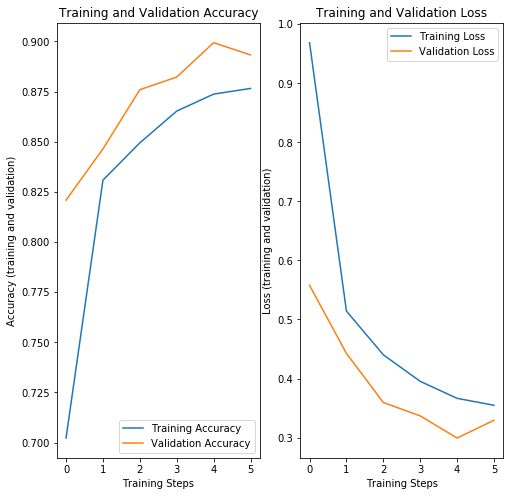

In [0]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Testing


In [0]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato Spider Mites, file: Tomato Spider Mites/0315776d-6d0d-4ae2-b102-4fd0feebaa51___Com.G_SpM_FL 9375.JPG
PREDICTED: class: Tomato Spider Mites, confidence: 0.950054


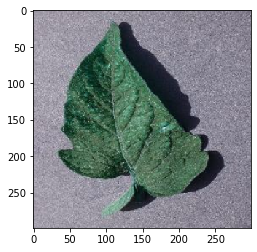

<Figure size 432x288 with 0 Axes>

SOURCE: class: Grape Esca, file: Grape Esca/a5162bb2-eee1-49ce-aa97-81b5453f7928___FAM_B.Msls 4244.JPG
PREDICTED: class: Grape Esca, confidence: 0.996184


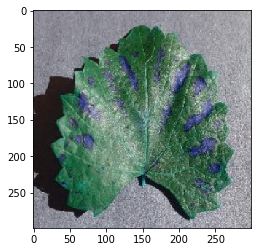

SOURCE: class: Corn Common Rust, file: Corn Common Rust/RS_Rust 2479.JPG
PREDICTED: class: Corn Common Rust, confidence: 0.999992


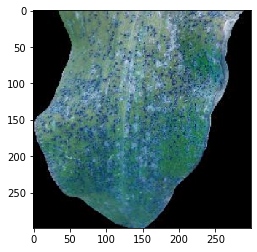

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato Spider Mites, file: Tomato Spider Mites/25025d43-973f-4f07-8a3f-0457749ea4e6___Com.G_SpM_FL 9642.JPG
PREDICTED: class: Tomato Spider Mites, confidence: 0.984907


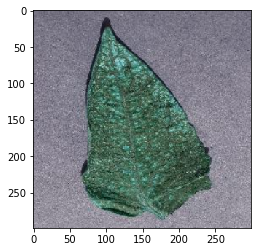

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato Yellow Leaf Curl Virus, file: Tomato Yellow Leaf Curl Virus/47b7e8f1-65eb-427f-a949-5da3e6b98884___UF.GRC_YLCV_Lab 03152.JPG
PREDICTED: class: Tomato Yellow Leaf Curl Virus, confidence: 0.691408


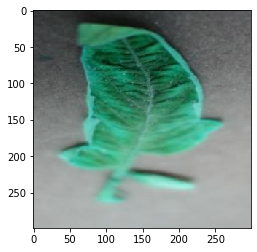

<Figure size 432x288 with 0 Axes>

In [0]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## Export saved model and convert it to TFLite


In [0]:
# import time
# t = time.time()

# export_path = "/tmp/saved_models/{}".format(int(t))
# #tf.keras.experimental.export_saved_model(model, export_path)
# tf.keras.models.save_model(model, export_path, save_format="tf")

# export_path

In [0]:
# # Now confirm that we can reload it, and it still gives the same results
# reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
# def predict_reload(image):
#     probabilities = reloaded.predict(np.asarray([img]))[0]
#     class_idx = np.argmax(probabilities)
    
#     return {classes[class_idx]: probabilities[class_idx]}

In [0]:
# for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
#     print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
#     img = load_image(filename)
#     prediction = predict_reload(img)
#     print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
#     plt.imshow(img)
#     plt.figure(idx)    
#     plt.show()

In [0]:
DISEASE_SAVED_MODEL = "saved_models/diseaseModel"
tf.saved_model.save(model, DISEASE_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_models/diseaseModel/assets


INFO:tensorflow:Assets written to: saved_models/diseaseModel/assets


In [0]:
disease_model = hub.load(DISEASE_SAVED_MODEL)
print(disease_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f99bc377780>


In [0]:

# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : disease_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
print(concrete_func)
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

91420296